# Modelling and Evaluation Notebook- Predict Sale Price 2

## Objectives

*   Fit and evaluate a Regression model to predict sale price, improving the model performance


## Inputs

* inputs/datasets/raw/house-price-20211124T154130Z-001
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot

## Additional comments

* My hypothesis concluded that YearBuilt may also be an important feature in predicting sale price. This was confirmed by the correlation study. I would like to test this hypotheis by including YearBuilt in the model to assess if it improves overall model performance. 

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-predictive-analytics/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-predictive-analytics'

# Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv")
      .drop(labels=['EnclosedPorch', 'WoodDeckSF' ], axis=1)  
  )

print(df.shape)
df.head(3)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = FullPipeline(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

# ML Pipeline with all data

## Refit ML Pipeline

In [7]:
selected_features = ['OverallQual', 'TotalBsmtSF', 'GarageArea', 'GrLivArea','YearBuilt']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import feature_engine.transformation as vt
from feature_engine.imputation import MeanMedianImputer

def FullPipeline(model):
    full_pipeline = Pipeline(steps=[
        
        # Apply Yeo-Johnson transformation
        ('yeo_johnson', vt.YeoJohnsonTransformer(variables=['GrLivArea'])),
        
        # Apply PowerTransformer to specific columns
        ("power_transform", vt.PowerTransformer(variables=['TotalBsmtSF'])),
        
        # Feature scaling
        ('feat_scaling', StandardScaler()),
        
        # Model
        ('model', model)
    ])
    
    return full_pipeline

## Split Train Test Set, only with selected best features

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


Subset selected features

In [10]:
X_train = X_train.filter(selected_features)
X_test = X_test.filter(selected_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)


,OverallQual,TotalBsmtSF,GarageArea,GrLivArea,YearBuilt
618,9,1822,774,1828,2007
870,5,894,308,894,1962
92,5,876,432,964,1921


## Grid Search CV – Sklearn

Check the most suitable alghorithm

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error


models = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [12]:
search = HyperparameterOptimizationSearch(models=models, params=params)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.698299,0.818549,0.868202,0.062457
3,ExtraTreesRegressor,0.698549,0.817529,0.874143,0.063156
5,GradientBoostingRegressor,0.654801,0.790277,0.858442,0.080075
6,XGBRegressor,0.692278,0.782567,0.827247,0.047396
0,LinearRegression,0.711158,0.764586,0.809417,0.03386
4,AdaBoostRegressor,0.555436,0.728919,0.813687,0.090306
1,DecisionTreeRegressor,0.554876,0.680898,0.764114,0.086197


Extensive Search against best alghorithms

In [14]:
models = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],  
        'model__max_features': ['sqrt', 0.5],  
        'model__max_depth': [10, None],  
        'model__min_samples_split': [2, 5],  
        'model__min_samples_leaf': [1, 2],  
    },
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 300],  
        'model__learning_rate': [0.05, 0.1], 
        'model__max_depth': [3, 5],  
        'model__min_samples_split': [2, 5], 
        'model__min_samples_leaf': [1, 2],  
        'model__subsample': [0.8, 1.0],  
        'model__max_features': ['sqrt', None],
        'model__loss': ['huber']
    },
    "RandomForestRegressor": {
        'model__n_estimators': [100, 300],  
        'model__max_features': ['sqrt', 0.5],  
        'model__max_depth': [10, None],  
        'model__min_samples_split': [2, 5],  
        'model__min_samples_leaf': [1, 2],  
        'model__bootstrap': [True, False],  
    },
}

In [15]:
search = HyperparameterOptimizationSearch(models=models, params=params)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 128 candidates, totalling 640 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 64 candidates, totalling 320 fits


Results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__subsample,model__bootstrap
28,ExtraTreesRegressor,0.781135,0.83748,0.874394,0.037138,None,0.5,2,2,100,NaN,NaN,NaN,NaN
20,ExtraTreesRegressor,0.781135,0.83748,0.874394,0.037138,None,sqrt,2,2,100,NaN,NaN,NaN,NaN
182,RandomForestRegressor,0.751774,0.836861,0.871975,0.047479,None,sqrt,2,5,100,NaN,NaN,NaN,True
190,RandomForestRegressor,0.751774,0.836861,0.871975,0.047479,None,0.5,2,5,100,NaN,NaN,NaN,True
19,ExtraTreesRegressor,0.753347,0.83643,0.879244,0.047005,None,sqrt,1,5,300,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,GradientBoostingRegressor,0.647499,0.784381,0.854064,0.083705,5,None,1,5,300,0.1,huber,0.8,NaN
144,GradientBoostingRegressor,0.660939,0.783593,0.851841,0.07884,5,None,1,2,100,0.1,huber,0.8,NaN
155,GradientBoostingRegressor,0.658878,0.783495,0.829107,0.063194,5,None,2,2,300,0.1,huber,1.0,NaN
119,GradientBoostingRegressor,0.668204,0.780099,0.854315,0.080763,3,None,1,5,300,0.1,huber,1.0,NaN


Best Model

In [17]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Best Params

In [18]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

Run with best Parameters

In [19]:
models = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100],  
        'model__max_features': ['sqrt'],  
        'model__max_depth': [None],  
        'model__min_samples_split': [2],  
        'model__min_samples_leaf': [2], 

    },
}

Results

In [20]:
search = HyperparameterOptimizationSearch(models=models, params=params)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [21]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.781135,0.83748,0.874394,0.037138,None,sqrt,2,2,100


Best Pipeline

In [22]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('yeo_johnson', YeoJohnsonTransformer(variables=['GrLivArea'])),
                ('power_transform',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2,
                                     random_state=0))])

## Assess feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageArea']


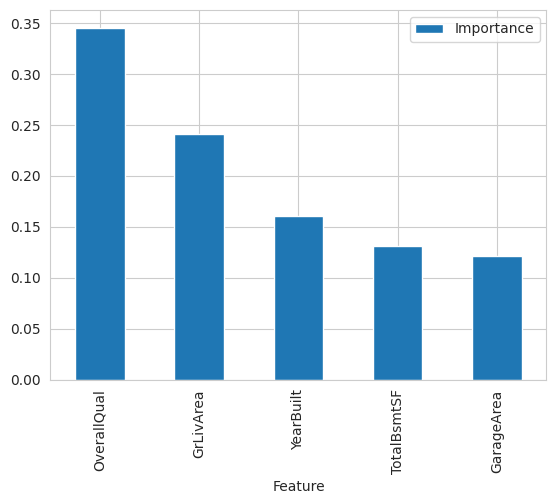

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [24]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluate regressor on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.922
Mean Absolute Error: 14049.79
Mean Squared Error: 481185019.309
Root Mean Squared Error: 21935.93


* Test Set
R2 Score: 0.822
Mean Absolute Error: 20223.778
Mean Squared Error: 1226290785.613
Root Mean Squared Error: 35018.435




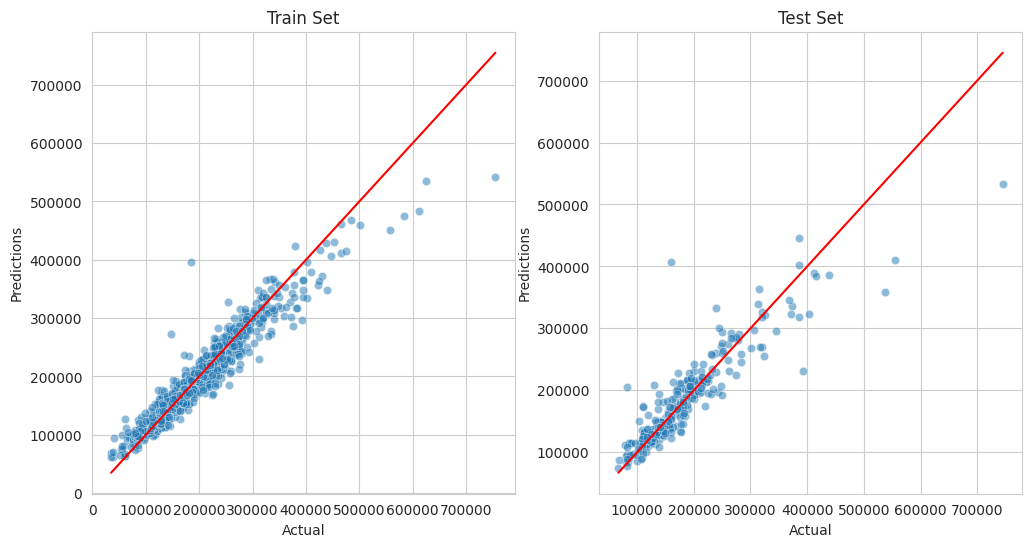

In [25]:

regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

* This model performs best, with lower errors in the MAE, MSE and RMSE and higher R2 scores for each set. 

## Conclusion

Adding YearBuilt to the model improves performance in the R2 score for both Train nad Test sets and reduces errors in the MAE, MSE and RMSE scores to give a more accurate prediction to sale price. I will use this model.

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* features importance plot

In [26]:
import joblib
import os

version = 'v2'
file_path = f'outputs/ml_pipeline/predict_SalePrice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [27]:
X_train.head()

,OverallQual,TotalBsmtSF,GarageArea,GrLivArea,YearBuilt
618,9,1822,774,1828,2007
870,5,894,308,894,1962
92,5,876,432,964,1921
817,8,1568,857,1689,2002
302,7,1541,843,1541,2001


In [28]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [29]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [30]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [31]:
X_test.head()

,OverallQual,TotalBsmtSF,GarageArea,GrLivArea,YearBuilt
529,6,2035,484,2515,1957
491,6,806,240,1578,1941
459,5,709,352,1203,1950
279,7,1160,505,2022,1977
655,6,525,264,1092,1971


In [32]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [33]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [34]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

In [35]:
best_regressor_pipeline

Pipeline(steps=[('yeo_johnson', YeoJohnsonTransformer(variables=['GrLivArea'])),
                ('power_transform',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2,
                                     random_state=0))])

In [36]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_SalePrice/v2/best_regressor_pipeline.pkl']

## Feature importance plot

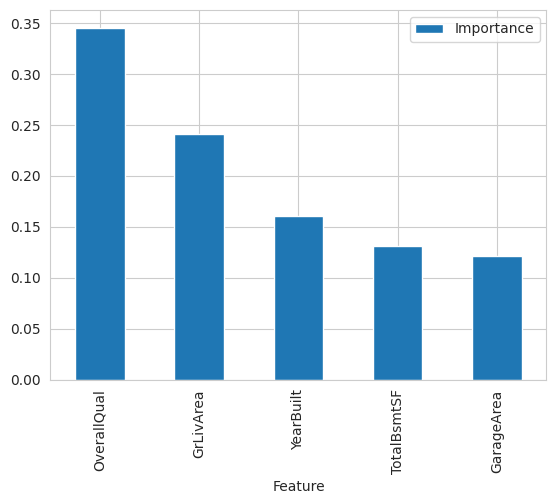

In [37]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

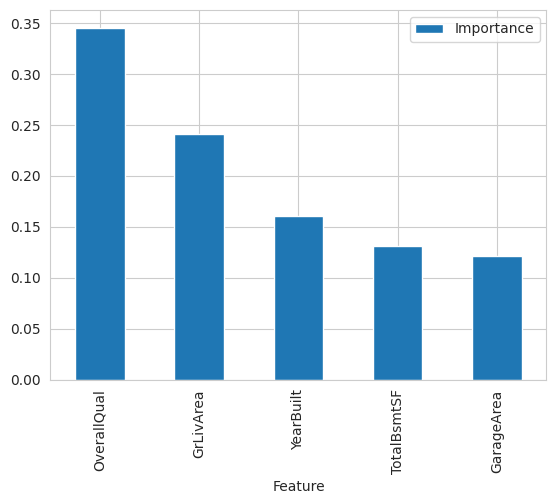

In [38]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')